In [2]:
import numpy as np

edges = np.loadtxt('filename.txt', dtype=int)
num_nodes = np.max(edges) + 1

adj_matrix = np.zeros((num_nodes, num_nodes))
for edge in edges:
    adj_matrix[edge[0], edge[1]] = 1
    adj_matrix[edge[1], edge[0]] = 1

print(adj_matrix.shape)


(1005, 1005)


In [3]:
import torch
x = torch.tensor(adj_matrix, dtype=torch.float)


In [4]:
row, col = np.where(adj_matrix == 1)

edge_index = np.stack((row, col), axis=0)
print(edge_index.shape)

(2, 32770)


In [5]:
edge_index = torch.tensor(edge_index, dtype=torch.long)

In [6]:
c = np.loadtxt('f2.txt', dtype=int)

num_nodes = np.max(c) + 1

communities = np.zeros((num_nodes))
for e in range(len(c)):
    communities[e] = c[e][1]

print(communities)

[ 1.  1. 21. ...  1.  6. 22.]


In [7]:
y = torch.tensor(communities, dtype=torch.long)
print(y)

tensor([ 1,  1, 21,  ...,  1,  6, 22])


In [8]:
import networkx as nx

def draw(lables, nodes):
  np.random.seed = 30
  cmap = plt.cm.get_cmap('hsv', 42)
  node_labels = np.array(lables)
  norm = plt.Normalize(vmin=node_labels.min(), vmax=node_labels.max())
  color_map = cmap(norm(node_labels))

  G = nx.Graph()
  G.add_nodes_from(nodes)
  G.add_edges_from(edges)


  nx.draw_random(G, with_labels=False, node_size=3, width=0.01, node_color=color_map)
  return G

In [9]:
nodes_all = []
lbls_all = []
for i, lbl in enumerate(y):
  nodes_all.append(i)
  lbls_all.append(lbl)
  

<ipython-input-8-de85fd0d3131>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 42)


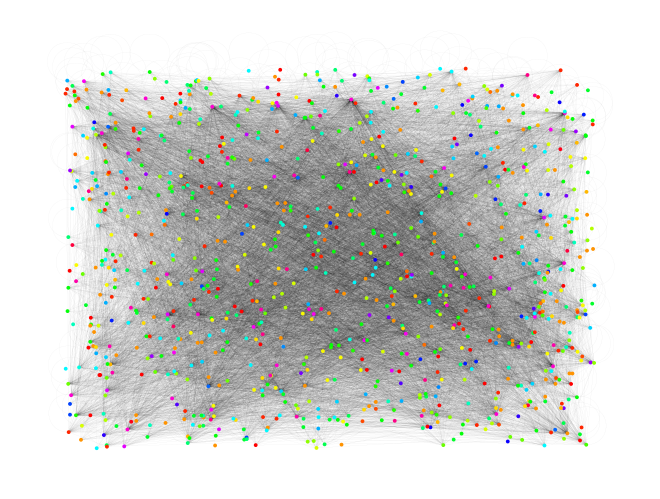

In [11]:
import matplotlib.pyplot as plt
g = draw(lbls_all, nodes_all)

In [12]:
print('♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥')
print(f'Number of nodes: {g.number_of_nodes()}') 
print('------------------------')
print(f'Number of edges: {g.number_of_edges()}') 
print('------------------------')
print(f'Maximum node degree: {max(dict(g.degree()).values())}') 
print('------------------------')
print(f'Minimum node degree: {min(dict(g.degree()).values())}') 
print('♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥')

♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥
Number of nodes: 1005
------------------------
Number of edges: 16706
------------------------
Maximum node degree: 347
------------------------
Minimum node degree: 1
♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥ ♥


In [ ]:
pip install torch_geometric

In [14]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_max_pool, BatchNorm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

num_classes = len(torch.unique(y))

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(x.shape[1], 64)
        self.bn1 = BatchNorm(64)
        self.conv2 = GCNConv(64, 128)
        self.bn2 = BatchNorm(128)
        self.conv3 = GCNConv(128, num_classes)
        # self.fc = torch.nn.Linear(16, num_classes)
        # self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x, edge):
        x = self.conv1(x, edge)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(input=x, training=self.training)
        x = self.conv2(x, edge)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(input=x, training=self.training)
        x = self.conv3(x, edge)

        return F.log_softmax(x, dim=1)


In [15]:
import torch.nn as nn
data = Data(x=x, edge_index=edge_index, y=y)
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_mask, test_mask = train_test_split(torch.arange(1004), test_size=0.8)
criterion = nn.CrossEntropyLoss()
print(train_mask.shape)

losses = []
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    # print(out[train_mask], y[train_mask])
    loss = criterion(input=out[train_mask], target=y[train_mask])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())



torch.Size([200])


In [16]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
output_notebook()

source = ColumnDataSource(data=dict(x=list(range(len(losses))), y=losses))
plot = figure(title='Training Loss', x_axis_label='Epoch', y_axis_label='Loss')
line = plot.line('x', 'y', source=source)
line.glyph.line_alpha = 0.8
line.glyph.line_color = "blue"
output_notebook()
show(plot)

In [17]:
model.eval()
out = model(data.x, data.edge_index)
_, pred = out.max(dim=1)
correct = pred[test_mask].eq(data.y[test_mask]).sum().item()
accuracy = correct / len(data.y[test_mask])
print('Accuracy: {:.4f}'.format(accuracy))


Accuracy: 0.5821


In [18]:
classes = torch.unique(y)
num_classes = len(classes)
print(f"Number of classes: {num_classes}")

Number of classes: 42


In [19]:
import matplotlib.pyplot as plt
import numpy as np
def get_n_m(x):
    n = int(x ** 0.5)
    while x % n != 0:
        n -= 1
    return tuple(sorted((n, x // n)))

def visualize(edges, nodes, labels, communities, x):
    np.random.seed = 30
    cmap = plt.cm.get_cmap('hsv', 42)
    node_labels = np.array(labels)
    norm = plt.Normalize(vmin=node_labels.min(), vmax=node_labels.max())
    color_map = cmap(norm(node_labels))

    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = {}
    n = np.ceil(x ** 0.5)
    print(n)

    for node, community in enumerate(communities):
        x = (community % n) * 10  + np.random.random() * 7
        y = (community // n) * 10 + np.random.random() * 7
        pos[node] = [x, y]

    nx.draw(G, pos=pos, with_labels=False, node_size=3, width=0.01, node_color=color_map)

In [20]:
nodes=[]
labels=[]
for i, lbl in enumerate(pred[test_mask]):
  nodes.append(i)
  labels.append(lbl)

In [21]:
len(pred)

1005

7.0


<ipython-input-19-d5dbbe1373d0>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 42)


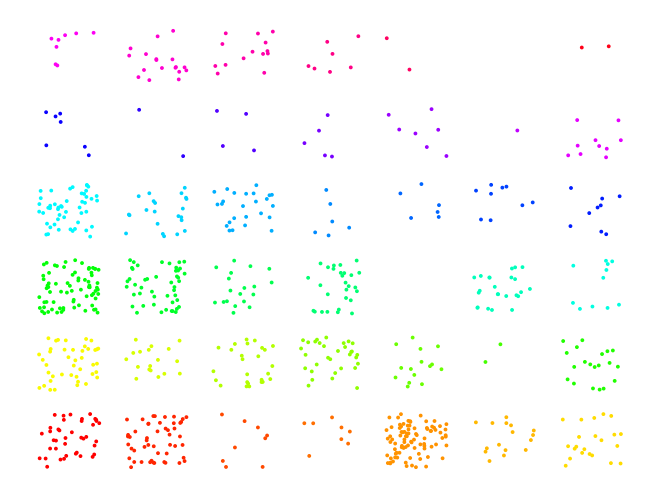

In [22]:
data.y[test_mask]
nodes_y=[]
labels_y=[]
for i, lbl in enumerate(data.y[test_mask]):
  nodes_y.append(i)
  labels_y.append(lbl)
visualize([ ], nodes_y, labels_y, labels_y, 42)

<ipython-input-19-d5dbbe1373d0>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('hsv', 42)


tensor(7.)


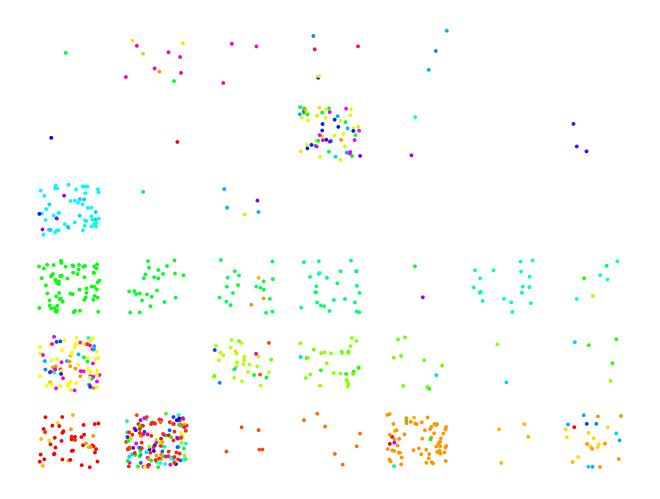

In [23]:
visualize([ ], nodes, labels_y, labels, max(pred))


In [24]:
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi_score_gnn = normalized_mutual_info_score(labels_y, labels)

In [25]:
print(f'Normalized mutual info score: {nmi_score_gnn}')

Normalized mutual info score: 0.6334036823743436


In [ ]:
pip install python-louvain

In [28]:
import community as community_lv
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
modularity_score = community_lv.modularity({i: pred[test_mask][i] for i in range(len(pred[test_mask]))}, G)
print("Modularity score: ", modularity_score)